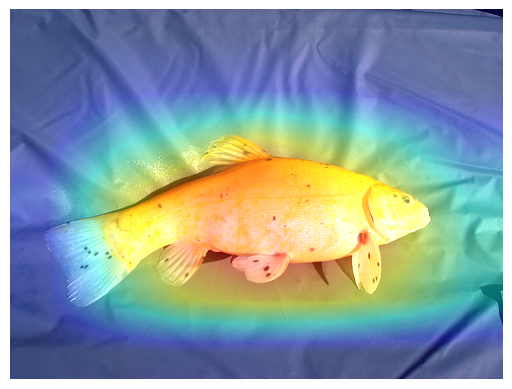

Total execution time: 0.0802 seconds
Forward pass time: 0.0185 seconds
Backward pass time: 0.0319 seconds
Heatmap generation time: 0.0206 seconds


In [5]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

model = models.resnet18(pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_path = 'n01440764_tench.JPEG'
img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        self.gradients = None
        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_full_backward_hook(backward_hook)

        output = self.model(x)

        handle_forward.remove()
        handle_backward.remove()

        return output

    def get_gradcam_heatmap(self, target_class):
        pooled_grads = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.squeeze()

        for i in range(len(pooled_grads)):
            activations[i, :, :] *= pooled_grads[i]

        heatmap = torch.mean(activations, dim=0).detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        return heatmap

start_time = time.time()

target_layer = model.layer4[1].conv2
grad_cam = GradCAM(model, target_layer)

forward_start_time = time.time()
output = grad_cam.forward(img_tensor)
forward_time = time.time() - forward_start_time

target_class = output.argmax().item()

backward_start_time = time.time()
model.zero_grad()
output[:, target_class].backward()
backward_time = time.time() - backward_start_time

heatmap_start_time = time.time()
heatmap = grad_cam.get_gradcam_heatmap(target_class)
heatmap_time = time.time() - heatmap_start_time

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

end_time = time.time()

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

total_time = end_time - start_time
print(f"Total execution time: {total_time:.4f} seconds")
print(f"Forward pass time: {forward_time:.4f} seconds")
print(f"Backward pass time: {backward_time:.4f} seconds")
print(f"Heatmap generation time: {heatmap_time:.4f} seconds")
